# Project: Investigate TMDB-Movie Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset we are go to investigate is the TMDb Movie Data (cleaned from the original data on Kaggle). This dataset contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue. Some notes on the dataset:
> - Certain columns, like 'cast', 'genres', 'director', and 'production companies' contain multiple values separated by pipe (|) characters. Since we are going to use 'genres' column for our research question, we will transform that column (split, merge, etc) to different cells for better processing.
> - The final two columns ending with “_adj” show the budget and revenue of the associated movie in terms of 2010 dollars, acounting for inflation over time.
> - There are missing values in some of the columns - which need to be cleaned.
> - The datatypes/formats of some of the columns (like 'release_date') need to be converted to another datatypes for easier processing.
> - Some columns (like revenue, budget, revenue_adj, budget_adj) have value 0, we will need to take care of these.

We will clean the data in following sequence:
1. Remove duplicate rows.
2. Drop the unnecessary columns.
3. Fill in missing values in a column if there are quite a few missing values - in 'director' and 'production_companies' columns, we will fill in 'Unknown' string.
4. Drop some rows with missing values if there are not too many rows - we will drop the missing rows which does not have 'genres' values. 
5. Convert the datatypes - change the release_date column to date_time format.
6. Replace the value 0 with the mean value of the column in certain columns (like revenue, budget, revenue_adj, and budget_adj) 
7. Split sample to multiple rows if the 'genres' column contains multiple values.

We like to investigate the dataset and find the answers to the following 2 research questions:
1. Which features (especially numerical features) in the dataset might have impact on revenue of the movie?
2. Which genres are most popular? Which genres make the most money?

We will build our report around analysis of the following
> - Dependent variable: revenue_adj, popularity
> - Independent variable: genre, release_year, budget_adj, runtime.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [2]:
# Let's load the dataset and take a look of the features.
df = pd.read_csv("tmdb-movies.csv")
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [3]:
df.shape

(10866, 21)

In [4]:
# Get more information
print(df.info())
print()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

### Data Cleaning

**Before doing anything, let's drop the duplicated rows.**

In [5]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 21 columns):
id                      10865 non-null int64
imdb_id                 10855 non-null object
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10789 non-null object
homepage                2936 non-null object
director                10821 non-null object
tagline                 8041 non-null object
keywords                9372 non-null object
overview                10861 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              1

**Feature 'id', 'imdb_id' does not seem to be very useful, we will drop these 2 columns. 'Homepage', 'tagline', 'keywords', 'overview' contains text messages - since we won't perform text/language processing on the data, and they are hard to convert to categorical data, we will drop them as well. We are not interested in building analysis report on 'cast', we will drop it too.**

In [5]:
# Drop the unnecessary columns
df.drop(['id', 'imdb_id', 'cast', 'homepage', 'tagline', 'keywords', 'overview'], axis=1, inplace=True)
print(df.head())
print()
print(df.info())

   popularity     budget     revenue                original_title  \
0   32.985763  150000000  1513528810                Jurassic World   
1   28.419936  150000000   378436354            Mad Max: Fury Road   
2   13.112507  110000000   295238201                     Insurgent   
3   11.173104  200000000  2068178225  Star Wars: The Force Awakens   
4    9.335014  190000000  1506249360                     Furious 7   

           director  runtime                                     genres  \
0   Colin Trevorrow      124  Action|Adventure|Science Fiction|Thriller   
1     George Miller      120  Action|Adventure|Science Fiction|Thriller   
2  Robert Schwentke      119         Adventure|Science Fiction|Thriller   
3       J.J. Abrams      136   Action|Adventure|Science Fiction|Fantasy   
4         James Wan      137                      Action|Crime|Thriller   

                                production_companies release_date  vote_count  \
0  Universal Studios|Amblin Entertainment|Legen

In [6]:
# There are quite a few null values in 'production_companies' and 'director', let's replace the null values in the columns with 'unknown'
df['director'] = df['director'].fillna('Unknown')
df['production_companies'] = df['production_companies'].fillna('Unknown')

print(df.query('director == "Unknown"').head(10))
print()
print(df.query('production_companies == "Unknown"').head(10))
print()
print(df.info())

      popularity   budget  revenue                         original_title  \
532     0.126594        0        0         Iliza Shlesinger: Freezing Hot   
548     0.108072        0        0             Sense8: Creating the World   
556     0.100910        0        0                         With This Ring   
1032    0.291253        0        0  Marvel Studios: Assembling a Universe   
1054    0.269468        0        0                     Unlocking Sherlock   
1203    0.119891   150000        0                           Free to Play   
1241    0.135376        0        0                              Dance-Off   
1288    0.038364        0        0      Top Gear: The Perfect Road Trip 2   
1852    0.256703        0        0                The Diary of Anne Frank   
1872    0.091395  3250000        0                                    Paa   

     director  runtime                       genres  \
532   Unknown       71                       Comedy   
548   Unknown       25  Documentary|Scienc

**There are 20+ null values in 'genres' column, let's see if we can drop the corresponding rows.**

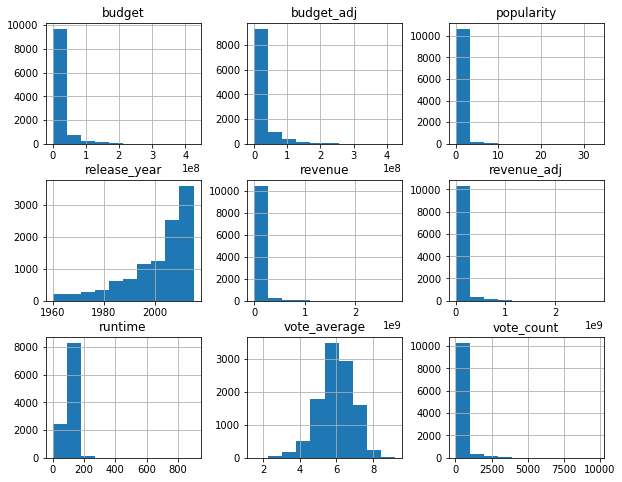

In [7]:
# Let's take a look the histogram of all the features
df.hist(figsize=(10,8));

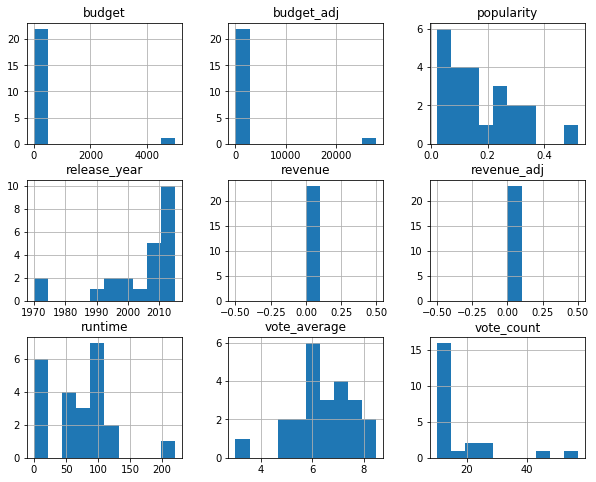

In [8]:
# Let's look at the histogram for the rows with null 'genres' value
df[df.genres.isnull()].hist(figsize=(10,8));

In [10]:
# Let's look at the rows with null 'genres' value
df[df.genres.isnull()]

,popularity,budget,revenue,original_title,director,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
424,0.244648,0,0,Belli di papÃ,Guido Chiesa,100,NaN,Unknown,10/29/15,21,6.1,2015,0.00000,0.0
620,0.129696,0,0,All Hallows' Eve 2,Antonio Padovan|Bryan Norton|Marc Roussel|Ryan...,90,NaN,Ruthless Pictures|Hollywood Shorts,10/6/15,13,5.0,2015,0.00000,0.0
997,0.330431,0,0,Star Wars Rebels: Spark of Rebellion,Steward Lee|Steven G. Lee,44,NaN,Unknown,10/3/14,13,6.8,2014,0.00000,0.0
1712,0.302095,0,0,Prayers for Bobby,Russell Mulcahy,88,NaN,Daniel Sladek Entertainment,2/27/09,57,7.4,2009,0.00000,0.0
1897,0.020701,0,0,Jonas Brothers: The Concert Experience,Bruce Hendricks,76,NaN,Unknown,2/27/09,11,7.0,2009,0.00000,0.0
2370,0.081892,0,0,Freshman Father,Michael Scott,0,NaN,Unknown,6/5/10,12,5.8,2010,0.00000,0.0
2376,0.068411,0,0,Doctor Who: A Christmas Carol,Unknown,62,NaN,Unknown,12/25/10,11,7.7,2010,0.00000,0.0
2853,0.130018,0,0,Vizontele,YÄ±lmaz ErdoÄŸan,110,NaN,Unknown,2/2/01,12,7.2,2001,0.00000,0.0
3279,0.145331,0,0,ì•„ê¸°ì™€ ë‚˜,Kim Jin-Yeong,96,NaN,Unknown,8/13/08,11,6.1,2008,0.00000,0.0
4547,0.520520,0,0,London 2012 Olympic Opening Ceremony: Isles of...,Danny Boyle,220,NaN,BBC,7/27/12,12,8.3,2012,0.00000,0.0


**Looks like there are a lot 0 value in revenue, revenue_adj, budget, and budget_adj. It should be safe for us to drop these rows**

In [11]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10843 entries, 0 to 10865
Data columns (total 14 columns):
popularity              10843 non-null float64
budget                  10843 non-null int64
revenue                 10843 non-null int64
original_title          10843 non-null object
director                10843 non-null object
runtime                 10843 non-null int64
genres                  10843 non-null object
production_companies    10843 non-null object
release_date            10843 non-null object
vote_count              10843 non-null int64
vote_average            10843 non-null float64
release_year            10843 non-null int64
budget_adj              10843 non-null float64
revenue_adj             10843 non-null float64
dtypes: float64(4), int64(5), object(5)
memory usage: 1.2+ MB


#### Start Converting Datatypes

**Let's just leave the first company in 'production_companies'. Since we will not use this column in our data analysis/research questions, it should be fine to do so.**

In [12]:
df['production_companies'] = df['production_companies'].apply(lambda x: x.split('|')[0])

print(df['production_companies'].head(20))

0                          Universal Studios
1                  Village Roadshow Pictures
2                       Summit Entertainment
3                                  Lucasfilm
4                         Universal Pictures
5                        Regency Enterprises
6                         Paramount Pictures
7     Twentieth Century Fox Film Corporation
8                         Universal Pictures
9                       Walt Disney Pictures
10                         Columbia Pictures
11                 Village Roadshow Pictures
12                                 DNA Films
13                         Columbia Pictures
14                            Marvel Studios
15                      Double Feature Films
16    Twentieth Century Fox Film Corporation
17                            Marvel Studios
18                      Walt Disney Pictures
19                         Studio Babelsberg
Name: production_companies, dtype: object


In [13]:
# Convert release_date (object datatype) to date.
df['release_date'] = pd.to_datetime(df['release_date'])

print(df.head(5))
print()
print(df.info())

   popularity     budget     revenue                original_title  \
0   32.985763  150000000  1513528810                Jurassic World   
1   28.419936  150000000   378436354            Mad Max: Fury Road   
2   13.112507  110000000   295238201                     Insurgent   
3   11.173104  200000000  2068178225  Star Wars: The Force Awakens   
4    9.335014  190000000  1506249360                     Furious 7   

           director  runtime                                     genres  \
0   Colin Trevorrow      124  Action|Adventure|Science Fiction|Thriller   
1     George Miller      120  Action|Adventure|Science Fiction|Thriller   
2  Robert Schwentke      119         Adventure|Science Fiction|Thriller   
3       J.J. Abrams      136   Action|Adventure|Science Fiction|Fantasy   
4         James Wan      137                      Action|Crime|Thriller   

        production_companies release_date  vote_count  vote_average  \
0          Universal Studios   2015-06-09        5562    

**Let's deal with the 0 value issue in the following 4 columns: budget_adj, budget, revenue, revenue_adj.**

In [14]:
# Let's find out how many rows carry non-zero values
budget_adj_nonzero = df[df['budget_adj'] != 0.0]
print(len(budget_adj_nonzero))

revenue_adj_nonzero = df[df['revenue_adj'] != 0.0]
print(len(revenue_adj_nonzero))

budget_nonzero = df[df['budget'] != 0.0]
print(len(budget_nonzero))

revenue_nonzero = df[df['revenue'] != 0.0]
print(len(revenue_nonzero))

5168
4849
5168
4849


**More than half of the column are 0 values. Let's replace those 0 value with the mean of the columns.**

In [14]:
budget_adj_mean = df['budget_adj'].mean()
df['budget_adj'] = df['budget_adj'].apply(lambda x: x if x != 0.0 else budget_adj_mean)

revenue_adj_mean = df['revenue_adj'].mean()
df['revenue_adj'] = df['revenue_adj'].apply(lambda x: x if x != 0.0 else revenue_adj_mean)

budget_mean = df['budget'].mean()
df['budget'] = df['budget'].apply(lambda x: x if x != 0.0 else budget_mean)

revenue_mean = df['revenue'].mean()
df['revenue'] = df['revenue'].apply(lambda x: x if x != 0.0 else revenue_mean)

print(df.head())
print()
print(df.info())

   popularity       budget       revenue                original_title  \
0   32.985763  150000000.0  1.513529e+09                Jurassic World   
1   28.419936  150000000.0  3.784364e+08            Mad Max: Fury Road   
2   13.112507  110000000.0  2.952382e+08                     Insurgent   
3   11.173104  200000000.0  2.068178e+09  Star Wars: The Force Awakens   
4    9.335014  190000000.0  1.506249e+09                     Furious 7   

           director  runtime                                     genres  \
0   Colin Trevorrow      124  Action|Adventure|Science Fiction|Thriller   
1     George Miller      120  Action|Adventure|Science Fiction|Thriller   
2  Robert Schwentke      119         Adventure|Science Fiction|Thriller   
3       J.J. Abrams      136   Action|Adventure|Science Fiction|Fantasy   
4         James Wan      137                      Action|Crime|Thriller   

        production_companies release_date  vote_count  vote_average  \
0          Universal Studios   20

**Let's transform 'genres' column now. Let's split a row to multiple rows if it has multiple values in 'genres' column.**

In [15]:
# Let's convert the single object string to list of strings if there is/are "|"(s) in the data for easy processing.
df['genres'] = df['genres'].apply(lambda x: x.split("|"))
print(df.head(20))

    popularity       budget       revenue  \
0    32.985763  150000000.0  1.513529e+09   
1    28.419936  150000000.0  3.784364e+08   
2    13.112507  110000000.0  2.952382e+08   
3    11.173104  200000000.0  2.068178e+09   
4     9.335014  190000000.0  1.506249e+09   
5     9.110700  135000000.0  5.329505e+08   
6     8.654359  155000000.0  4.406035e+08   
7     7.667400  108000000.0  5.953803e+08   
8     7.404165   74000000.0  1.156731e+09   
9     6.326804  175000000.0  8.537086e+08   
10    6.200282  245000000.0  8.806746e+08   
11    6.189369  176000003.0  1.839877e+08   
12    6.118847   15000000.0  3.686941e+07   
13    5.984995   88000000.0  2.436371e+08   
14    5.944927  280000000.0  1.405036e+09   
15    5.898400   44000000.0  1.557601e+08   
16    5.749758   48000000.0  3.257714e+08   
17    5.573184  130000000.0  5.186022e+08   
18    5.556818   95000000.0  5.423514e+08   
19    5.476958  160000000.0  6.505234e+08   

                           original_title             

In [16]:
# Get the rest of columns except 'genres' 
cols = list(df.columns)
cols.remove('genres')

In [17]:
# The transformation steps
df = df.genres.apply(pd.Series) \
    .merge(df, right_index = True, left_index = True) \
    .drop(["genres"], axis = 1) \
    .melt(id_vars = cols, value_name = "genre") \
    .drop("variable", axis = 1) \
    .dropna()

In [18]:
# Reset index afterwards
df.reset_index(drop=True,inplace=True)
print(df.head())
print()
print(df.info())
print()
print(df.describe())

   popularity       budget       revenue                original_title  \
0   32.985763  150000000.0  1.513529e+09                Jurassic World   
1   28.419936  150000000.0  3.784364e+08            Mad Max: Fury Road   
2   13.112507  110000000.0  2.952382e+08                     Insurgent   
3   11.173104  200000000.0  2.068178e+09  Star Wars: The Force Awakens   
4    9.335014  190000000.0  1.506249e+09                     Furious 7   

           director  runtime       production_companies release_date  \
0   Colin Trevorrow      124          Universal Studios   2015-06-09   
1     George Miller      120  Village Roadshow Pictures   2015-05-13   
2  Robert Schwentke      119       Summit Entertainment   2015-03-18   
3       J.J. Abrams      136                  Lucasfilm   2015-12-15   
4         James Wan      137         Universal Pictures   2015-04-01   

   vote_count  vote_average  release_year    budget_adj   revenue_adj  \
0        5562           6.5          2015  1.3799

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 - Which features (especially numerical features) in the dataset might have impact on revenue of the movie?

Let's find out the correlation matrix of the dataframe and use Seaborn heatmap to visualize the correlations between numerical features.

              popularity    budget   revenue   runtime  vote_count  \
popularity      1.000000  0.519771  0.643892  0.142403    0.794882   
budget          0.519771  1.000000  0.702840  0.182413    0.629800   
revenue         0.643892  0.702840  1.000000  0.152511    0.783968   
runtime         0.142403  0.182413  0.152511  1.000000    0.174374   
vote_count      0.794882  0.629800  0.783968  0.174374    1.000000   
vote_average    0.233374  0.091474  0.175938  0.158623    0.279329   
release_year    0.110135  0.158889  0.087962 -0.135188    0.131346   
budget_adj      0.484825  0.961901  0.671335  0.220668    0.581900   
revenue_adj     0.585795  0.575396  0.912524  0.167951    0.696976   

              vote_average  release_year  budget_adj  revenue_adj  
popularity        0.233374      0.110135    0.484825     0.585795  
budget            0.091474      0.158889    0.961901     0.575396  
revenue           0.175938      0.087962    0.671335     0.912524  
runtime           0.158623 

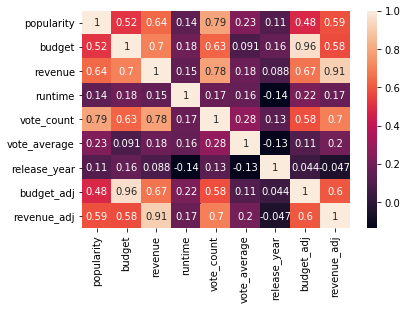

In [19]:
corr = df.corr()
print(corr)
sns.heatmap(corr, annot=True);

**Looks like popularity, budget and vote_count have stronger correlations with revenue, while runtime does not have strong correlation with revenue. Since we can probably imagine popularity and vote_count might have direct impact on revenue, let's skip investgating these features and just plot out budget and runtime to see if the plots are consistent with what's shown by the correlation matrix.**

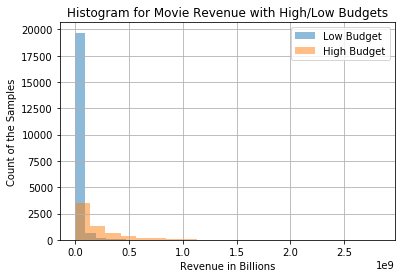

In [20]:
# Divide budget into two groups (low budget, high budget) using the mean value of the budget.
budget_low = df['budget_adj'] <= df['budget_adj'].mean()
budget_high = df['budget_adj'] > df['budget_adj'].mean()
df.revenue_adj[budget_low].hist(label='Low Budget', alpha=0.5, bins=20);
df.revenue_adj[budget_high].hist(label='High Budget', alpha=0.5, bins=20);
plt.xlabel("Revenue in Billions");
plt.ylabel("Count of the Samples");
plt.title("Histogram for Movie Revenue with High/Low Budgets")
plt.legend();

**From the above plots, we can tell that:**
> - Mean revenue for movies with low budget are lower.
> - Mean revenue for movies with high budget are higher - they might be higher than 1 billion and should be over 0.1 billion on average.

**We may coclude that the budget of the movie has postive impact on the reveune of the movie!!**

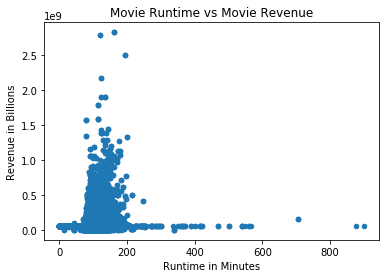

In [21]:
df.plot(x='runtime', y='revenue_adj', kind='scatter');
plt.xlabel("Runtime in Minutes");
plt.ylabel("Revenue in Billions");
plt.title("Movie Runtime vs Movie Revenue");

**From the scatter plot, we can tell that runtime of the movie does not have strong correlation with the revenue of the movie - which is consistent with the indication from the correlation matrix.**

### Research Question 2 - Which genres are most popular? Which genres make the most money?
#### Question 2.1 - Which genres are most popular over the years?

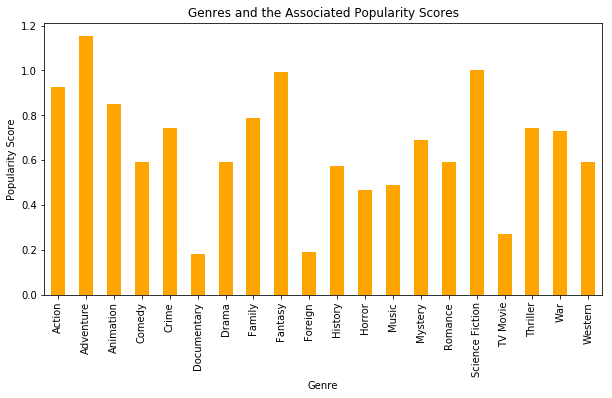

In [33]:
# Let's groupby 'genre' and get mean on 'popularity'.
g1 = df.groupby('genre').popularity.mean()
g1.plot(kind='bar', color='orange', figsize=(10,5));
plt.xlabel("Genre")
plt.ylabel("Popularity Score");
plt.title("Genres and the Associated Popularity Scores");

In [34]:
# It's hard to say which genres are top 2, 3 most popular. Let's sort the groupby result and print out.
g1.sort_values(ascending=False)

genre
Adventure          1.154259
Science Fiction    1.001548
Fantasy            0.992840
Action             0.926274
Animation          0.852182
Family             0.786668
Crime              0.744930
Thriller           0.741563
War                0.727683
Mystery            0.690012
Comedy             0.592607
Romance            0.592082
Drama              0.591495
Western            0.590615
History            0.575936
Music              0.487321
Horror             0.465357
TV Movie           0.270896
Foreign            0.191496
Documentary        0.181432
Name: popularity, dtype: float64

**From the plot and sorted groupby output, we can tell that the top 3 most popular genres (from 1960 to 2015) are: adventure, science fiction and fantasy.**


#### Question 2.2 - Which genres make the most money over the years?

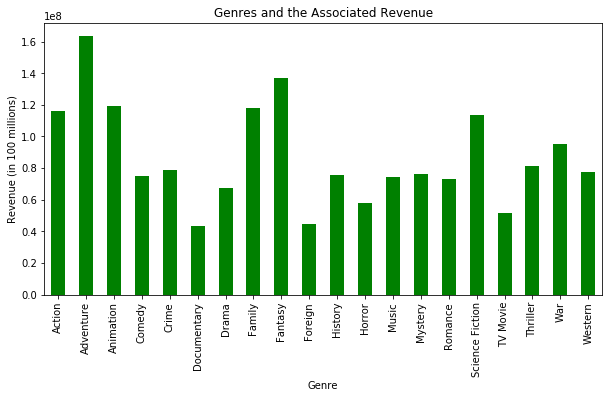

In [23]:
# Let's groupby 'genre' and get mean on revenue
g1 = df.groupby('genre').revenue_adj.mean()
g1.plot(kind='bar', color='green', figsize=(10,5));
plt.xlabel("Genre")
plt.ylabel("Revenue (in 100 millions)")
plt.title("Genres and the Associated Revenue");

In [24]:
g1.sort_values(ascending=False)

genre
Adventure          1.636502e+08
Fantasy            1.368022e+08
Animation          1.192771e+08
Family             1.177593e+08
Action             1.159785e+08
Science Fiction    1.138169e+08
War                9.534149e+07
Thriller           8.153510e+07
Crime              7.866617e+07
Western            7.729721e+07
Mystery            7.630822e+07
History            7.584281e+07
Comedy             7.533677e+07
Music              7.466346e+07
Romance            7.330549e+07
Drama              6.728612e+07
Horror             5.791612e+07
TV Movie           5.151473e+07
Foreign            4.476998e+07
Documentary        4.363484e+07
Name: revenue_adj, dtype: float64

**From the above plot and sorted groupby output, we can tell that the top 3 genres that make the most money are: adventure, fantasy and animation.** 


#### Question 2.3 - Which are the most popular genres in each release year (from 2013-2015)?

In [20]:
# Let's make a dataframe from the original dataframe which just contains data from 2013-2015.
df_last_three_years = df[df['release_year'] >= 2013]

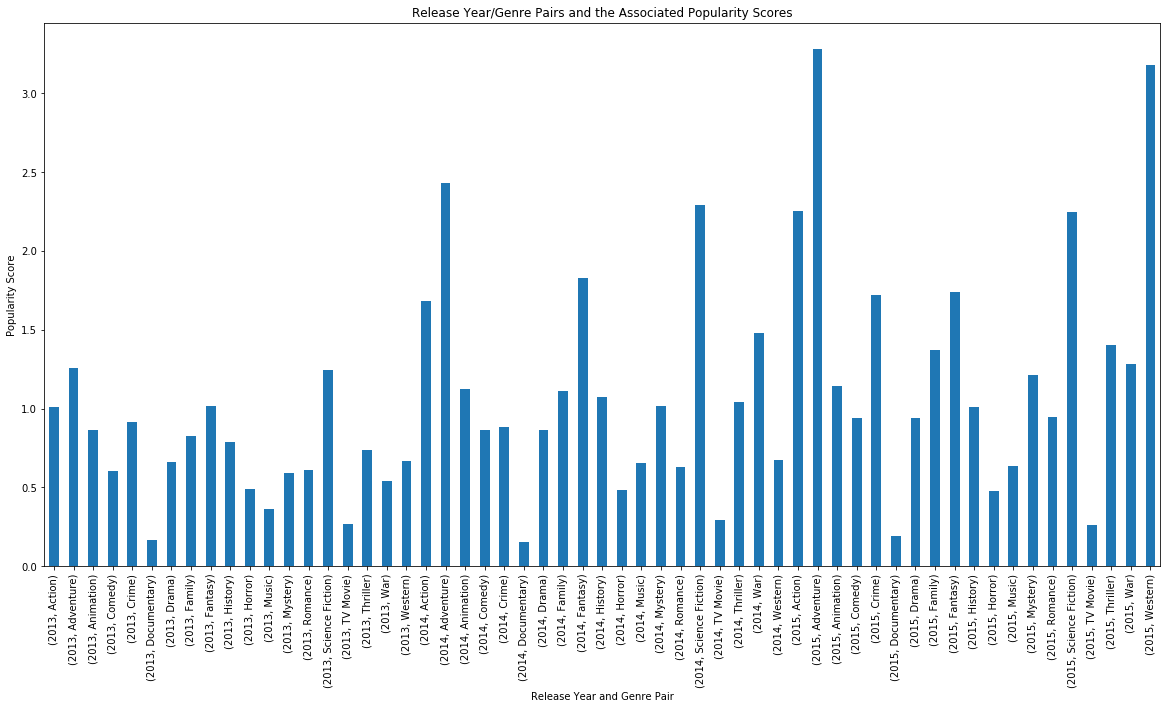

In [21]:
# Let's groupby 'release_year' and 'genre', and get mean on popularity.
g1 = df_last_three_years.groupby(['release_year','genre']).popularity.mean()
g1.plot(kind='bar', figsize=(20, 10));
plt.xlabel("Release Year and Genre Pair")
plt.ylabel("Popularity Score")
plt.title("Release Year/Genre Pairs and the Associated Popularity Scores");

In [22]:
g1.sort_values()

release_year  genre          
2014          Documentary        0.151321
2013          Documentary        0.166475
2015          Documentary        0.190483
              TV Movie           0.260574
2013          TV Movie           0.267746
2014          TV Movie           0.296038
2013          Music              0.360312
2015          Horror             0.476670
2014          Horror             0.483898
2013          Horror             0.491909
              War                0.538608
              Mystery            0.590179
              Comedy             0.603933
              Romance            0.610802
2014          Romance            0.629171
2015          Music              0.635101
2014          Music              0.652112
2013          Drama              0.660076
              Western            0.665255
2014          Western            0.673947
2013          Thriller           0.734572
              History            0.788779
              Family             0.823464
    

**From above plot, we can tell that:**
> - In 2013, the top 3 most popular genres are: adventure, science fiction and fantasy.
> - In 2014, the top 3 most popular genres are: adventure, science fiction and fantasy.
> - In 2015, the top 3 most popular genres are: adventure, western and action.

**We can conclude that 'adventure' is the top 1 most popular genre from 2013-2015.**

#### Question 2.4 - Which are the most popular genres in each 20-year period (from 1960 to 2015)?

**To visualize the most popular genres over the decades, let's make a new column, which categorizes the release year into three 20-year periods: 1960-1979, 1980-1999, 2000 and up, then plot out the most popular genres.**

In [38]:
# Make the new column and fill in the corresponding release year initially.
df['release_year_double_decades'] = df['release_year']

In [39]:
# Function transforms the release year to three 20-year periods.
def transform_year_to_double_decade(year):
    if year >= 1960 and year < 1980:
        return "Year 1960-1979"
    elif year >= 1980 and year < 2000:
        return "Year 1980-1999"
    else:
        return "Year 2000 and up"
df['release_year_double_decades'] = df['release_year_double_decades'].apply(transform_year_to_double_decade)

print(df.head())
print()
print(df.info())

   popularity       budget       revenue                original_title  \
0   32.985763  150000000.0  1.513529e+09                Jurassic World   
1   28.419936  150000000.0  3.784364e+08            Mad Max: Fury Road   
2   13.112507  110000000.0  2.952382e+08                     Insurgent   
3   11.173104  200000000.0  2.068178e+09  Star Wars: The Force Awakens   
4    9.335014  190000000.0  1.506249e+09                     Furious 7   

           director  runtime       production_companies release_date  \
0   Colin Trevorrow      124          Universal Studios   2015-06-09   
1     George Miller      120  Village Roadshow Pictures   2015-05-13   
2  Robert Schwentke      119       Summit Entertainment   2015-03-18   
3       J.J. Abrams      136                  Lucasfilm   2015-12-15   
4         James Wan      137         Universal Pictures   2015-04-01   

   vote_count  vote_average  release_year    budget_adj   revenue_adj  \
0        5562           6.5          2015  1.3799

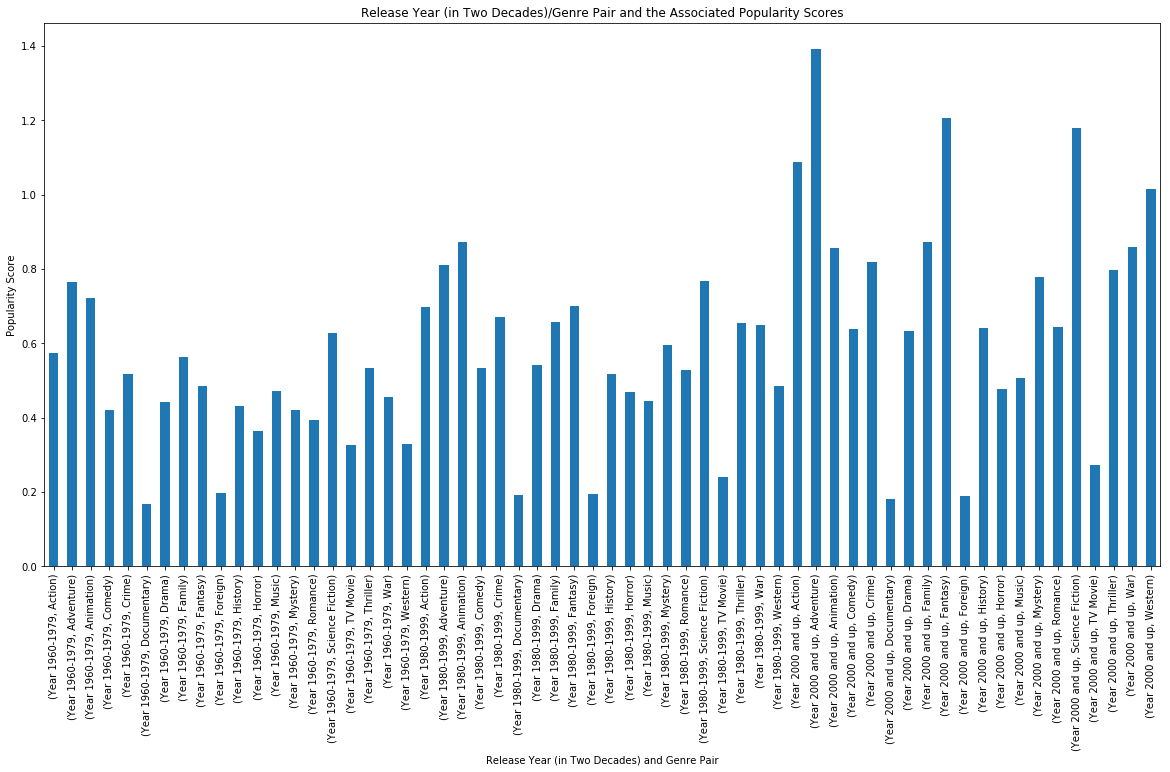

In [40]:
# Let's plot groupby 'release_year_double_decades and genre' and get the mean on popularity.
df.groupby(['release_year_double_decades','genre']).popularity.mean().plot(kind='bar', figsize=(20, 10));
plt.xlabel("Release Year (in Two Decades) and Genre Pair")
plt.ylabel("Popularity Score")
plt.title("Release Year (in Two Decades)/Genre Pair and the Associated Popularity Scores");

**From above plots, we can tell that:**
> - From 1960 to 1979, the top 3 most popular movie genres are: adventure, animation and science fiction.
> - From 1980 to 2000, the top 3 most popular movie genres are: animation, adventure and science fiction.
> - From 2000 to 2015, the top 3 most popular movie genres are: adventure, fantasy, and science fiction.

**'Adventure' and 'Science Fiction' remain in the most popular genre list in all the double-decades!**

<a id='conclusions'></a>
## Conclusions:
### Research Question 1 - Which features (especially numerical features) in the dataset might have impact on revenue of the movie?
**Answer**: budget has the strong positive impact on the revenue of the movie. The limitation of my analysis is: there are too many 0 value in revenue_adj and budget_adj columns, so we have to replace those with the mean value of the column, hope this will not change the fact that budget has postive impact on revenue. I think features like 'director'/'cast'/'production_companies' also have some impact on the revenue of the movie. However, these columns contains multiple values hence take a lot effort to transform them. So we just do data analysis without considering these features.


### Research Question 2 - Which Genres Are Most Popular? Which Genres Make the Most Money?
**Answer:**
> - The top 3 most popular genres (from 1960 to 2015) are: adventure, science fiction and fantasy.

> - The top 3 genres that make the most money are: adventure, fantasy and animation. 

> - In 2013, the top 3 most popular genres are: adventure, science fiction and fantasy.
> - In 2014, the top 3 most popular genres are: adventure, science fiction and fantasy.
> - In 2015, the top 3 most popular genres are: adventure, western and action.
> - 'Adventure' is the top most popular genre from 2013-2015.

> - From 1960 to 1979, the top 3 most popular movie genres are: adventure, animation and science fiction.
> - From 1980 to 2000, the top 3 most popular movie genres are: animation, adventure and science fiction.
> - From 2000 to 2015, the top 3 most popular movie genres are: adventure, fantasy, and science fiction.
> - 'Adventure' and 'Science Fiction' remain in the most popular genre list in all the double-decades!